# Dispersion statistic

This notebook corresponds to the section titled "Compares variability between dEEG and dMEG" and corresponds to the `dispersion_stats_analysis` function from the `MEEG_fMRI_whole_compa_script.py` script.

Within this notebook, you can perform the dispersion analysis using either an R script (`dispersion_analysis.R` with the `dispersion_analysis_R` function from `utils.stats_utils`) or a Python script (`dispersion_analysis_python` from `utils.stats_utils`). Both scripts are designed to achieve the same results, but the Python script generally takes longer to execute compared to the R script.

The goal of these scripts is to determine whether the variances of dMEG and dEEG are significantly different.

## Import the necessary libraries

In [1]:
# Import necessary libraries
from skbio.stats.distance import permdisp, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Personal Imports
# Add the directory that contains the utils package to sys.path
sys.path.append(str(Path('..').resolve()))
from utils.dispersion_stats_analysis_utils import significance_code, compute_dispersion_analysis
from utils.utils import load_df_from_csv, flatten_columns
from utils.plot_utils import *
from utils.stats_utils import dispersion_analysis_R, dispersion_analysis_python
from utils.df_utils import reshape_dataframe

## Set the different path

Before running the notebooks, ensure that you update the paths in `config.py` to match your local setup:

- **`LOCAL_DIR`**: Set this to the directory where your BIDS-formatted data is stored.
- **`R_WORKING_DIRECTORY`**: Specify the directory where your R scripts are saved.
- **`RSCRIPT_EXECUTABLE`**: Provide the path to the `Rscript` executable on your computer. For more details, refer to `config.md`.

In [2]:
from config import LOCAL_DIR, R_WORKING_DIRECTORY, RSCRIPT_EXECUTABLE
local_dir = LOCAL_DIR
working_directory = R_WORKING_DIRECTORY

# Define the Rscript executable path if necessary (otherwise, use just 'Rscript')
rscript_executable = RSCRIPT_EXECUTABLE  # or provide the full path if needed

## Proceed to dispersion statistical analyis

### Explanation of the python Process

1. **Loading Data:**
   - The function begins by loading the POA (Point of Analysis) or wCOG (weighted Center of Gravity) data from an Excel file, which contains pre-computed Euclidean distances.

2. **Data Reshaping:**
   - The `reshape_dataframe` function from `utils.stats_analysis_utils` is used to transform the `data_df` DataFrame. This function reorganizes the data by placing the EEG and MEG distance columns sequentially and adds a new column named 'modality'. This column categorizes the data into two groups: 'eeg' and 'meg', facilitating comparison between these modalities.

3. **Dispersion Analysis:**
   - For each combination of time point (tp) and condition, the function performs a Distance-Based Test for Homogeneity of Multivariate Dispersion. This involves comparing the dispersion of distances between EEG and MEG groups using the `permdisp` function from `scikit-bio`. The `permdisp` function assesses whether the multivariate dispersion (i.e., variability) of the two groups is significantly different.

4. **Results and Plotting:**
   - The results of the dispersion tests are compiled into a DataFrame, which is then saved as an Excel file at the specified `path_to_data` directory under the filename `all_subjects_analysis-POA/COG_modality_comparison_analysis-dispersion_python.csv`. 
   - If any of the comparisons yield significant differences, a PCA (Principal Component Analysis) plot is generated and saved.

5. **Parameters:**
   - The function allows you to specify two parameters:
     - `nb_permu`: The number of permutations to be used in the dispersion test. This parameter affects the robustness and accuracy of the p-value estimation.
     - `dist_metric`: The distance metric used for calculating distances. Common choices include 'euclidean', 'manhattan', etc. This metric determines how distances between points are measured and can impact the results of the dispersion test.

### Explanation of the R Process

1. **Loading Data:**
   - The function begins by loading the POA (Point of Analysis) or wCOG (weighted Center of Gravity) data from an Excel file, which contains pre-computed Euclidean distances.

2. **Data Reshaping:**
   - The `reshape_dataframe` function from `statistical_dispersion_analysis_utils.R` is used to transform the `data_df` DataFrame. This function reorganizes the data by placing the EEG and MEG distance columns sequentially and adds a new column named 'modality'. This column categorizes the data into two groups: 'eeg' and 'meg', facilitating comparison between these modalities.

3. **Dispersion Analysis:**
   - For each combination of time point (tp) and condition, the function performs a Distance-Based Test for Homogeneity of Multivariate Dispersion. This involves comparing the dispersion of distances between EEG and MEG groups using the `betadisper` function from `vegan`. The `betadisper` function assesses whether the multivariate dispersion (i.e., variability) of the two groups is significantly different.

4. **Results and Plotting:**
   - The results of the dispersion tests are compiled into a DataFrame, which is then saved as an Excel file at the specified `path_to_data` directory under the filename `all_subjects_analysis-POA/COG_modality_comparison_analysis-dispersion_R.csv`. 
   - If any of the comparisons yield significant differences, a PCA (Principal Component Analysis) plot is generated and saved.

5. **Parameters:**
   - The function allows you to specify two parameters:
     - `nb_permu`: The number of permutations to be used in the dispersion test. This parameter affects the robustness and accuracy of the p-value estimation.
     - `dist_metric`: The distance metric used for calculating distances. Common choices include 'euclidean', 'manhattan', etc. This metric determines how distances between points are measured and can impact the results of the dispersion test.

### **References:**
   - For more information on the `permdisp` function, refer to the [scikit-bio documentation](https://scikit.bio/docs/dev/generated/skbio.stats.distance.permdisp.html).
   - For more information on the `betadisper` function, refer to the [vegan package documentation](https://search.r-project.org/CRAN/refmans/vegan/html/betadisper.html).
   - For theoretical background on distance-based tests for multivariate dispersion, consult the article:
       - **Anderson, M.J.** (2006). Distance-based tests for homogeneity of multivariate dispersions. *Biometrics*, 62(1), 245-253. [DOI: 10.1111/j.1541-0420.2005.00440.x](https://doi.org/10.1111/j.1541-0420.2005.00440.x). PMID: [16542252](https://pubmed.ncbi.nlm.nih.gov/16542252).

### The DataFrames

Both DataFrames include the following columns:

- **condition**: The condition identifier.
- **tp**: The time point identifier.
- **method_name**: The function used to compute the statistics (e.g., betadisper).
- **test_statistic_name**: The type of statistic computed.
- **sample_size**: The sample size.
- **number_of_groups**: The number of groups (two groups: meg and eeg).
- **test_statistic**: The value of the test statistic (i.e., F-test).
- **p_value**: The computed p-value.
- **number_of_permutations**: The number of permutations used in the analysis.

In R, additional columns are:

- **Df**: The degrees of freedom.
- **mean_sq**: The mean sum of squares, calculated by dividing the sum of squares by the degrees of freedom. It represents the average variation per degree of freedom and is used in calculating the F-statistic in ANOVA.
- **sum_sq**: The sum of squares, which quantifies the total variation in distances to the group centroid (or median).


Using the Python script for dispersion analysis.
Beginning POA dispersion analysis using Python.
  Info_SubjectName Info_task Info_condition Info_tpindex Info_fmridx Dist_x  \
0           sub-03       aud           sine            0           2   -5.9   
1           sub-03       aud           sine            1           3 -51.81   
2           sub-03       aud           sine            2           1 -24.07   
3           sub-03       aud         piano1            0           1   0.45   
4           sub-03       aud         piano1            1           1  28.69   

  Dist_y Dist_z Dist_norm modality  
0  -1.89  -2.36      6.63      eeg  
1   4.47  -50.2     72.28      eeg  
2  19.93   1.91      31.3      eeg  
3   0.49  -9.98      10.0      eeg  
4   18.7 -13.83     36.93      eeg  
    Info_SubjectName Info_task Info_condition Info_tpindex Info_fmridx  \
0             sub-03       aud           sine            0           2   
1             sub-03       aud           sine            1

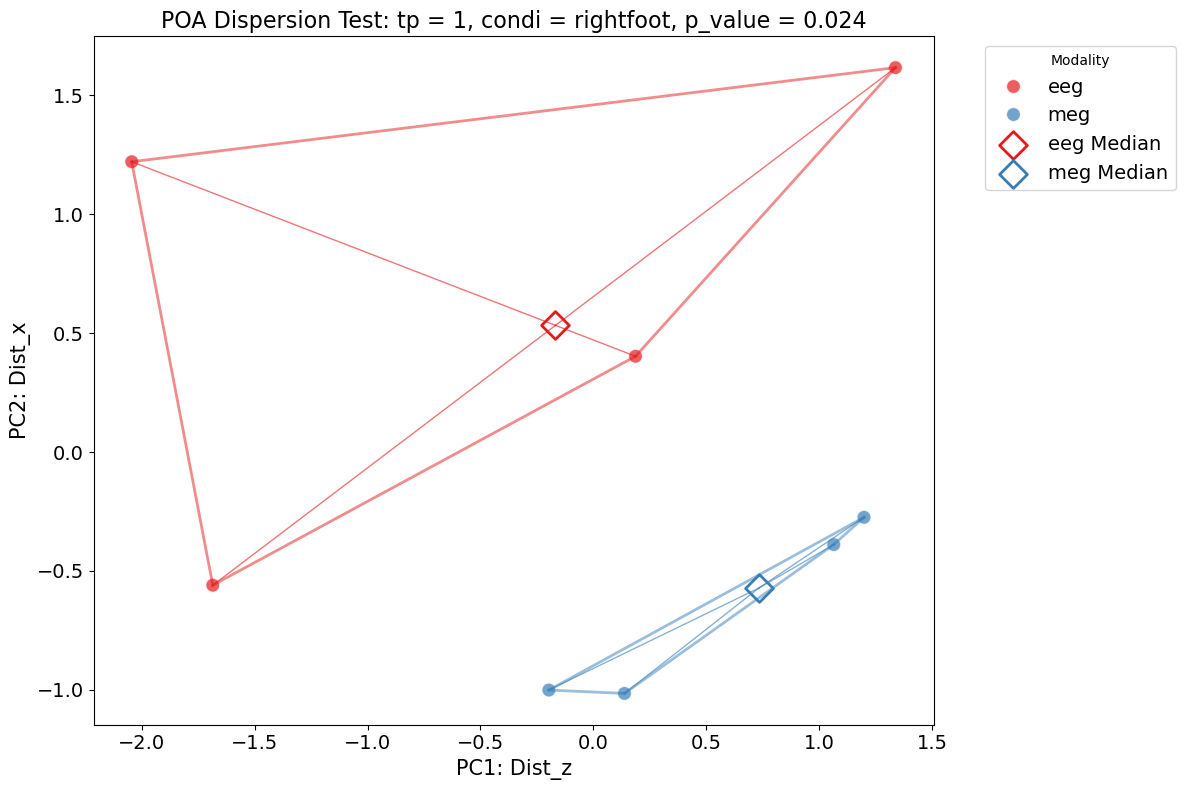

Beginning COG dispersion analysis using Python.
  Info_SubjectName Info_task Info_condition Info_tpindex Info_fmridx Dist_x  \
0           sub-03       aud           sine            0           2    2.7   
1           sub-03       aud           sine            1           3  -9.79   
2           sub-03       aud           sine            2           3   7.09   
3           sub-03       aud         piano1            0           1  -0.31   
4           sub-03       aud         piano1            1           1  -9.02   

  Dist_y Dist_z Dist_norm modality  
0  -1.75  -5.37      6.26      eeg  
1   8.65 -30.78     33.44      eeg  
2  -2.23   6.63      9.96      eeg  
3  -0.24  -5.53      5.54      eeg  
4   7.19  -7.07     13.53      eeg  
    Info_SubjectName Info_task Info_condition Info_tpindex Info_fmridx  \
0             sub-03       aud           sine            0           2   
1             sub-03       aud           sine            1           3   
2             sub-03       aud   

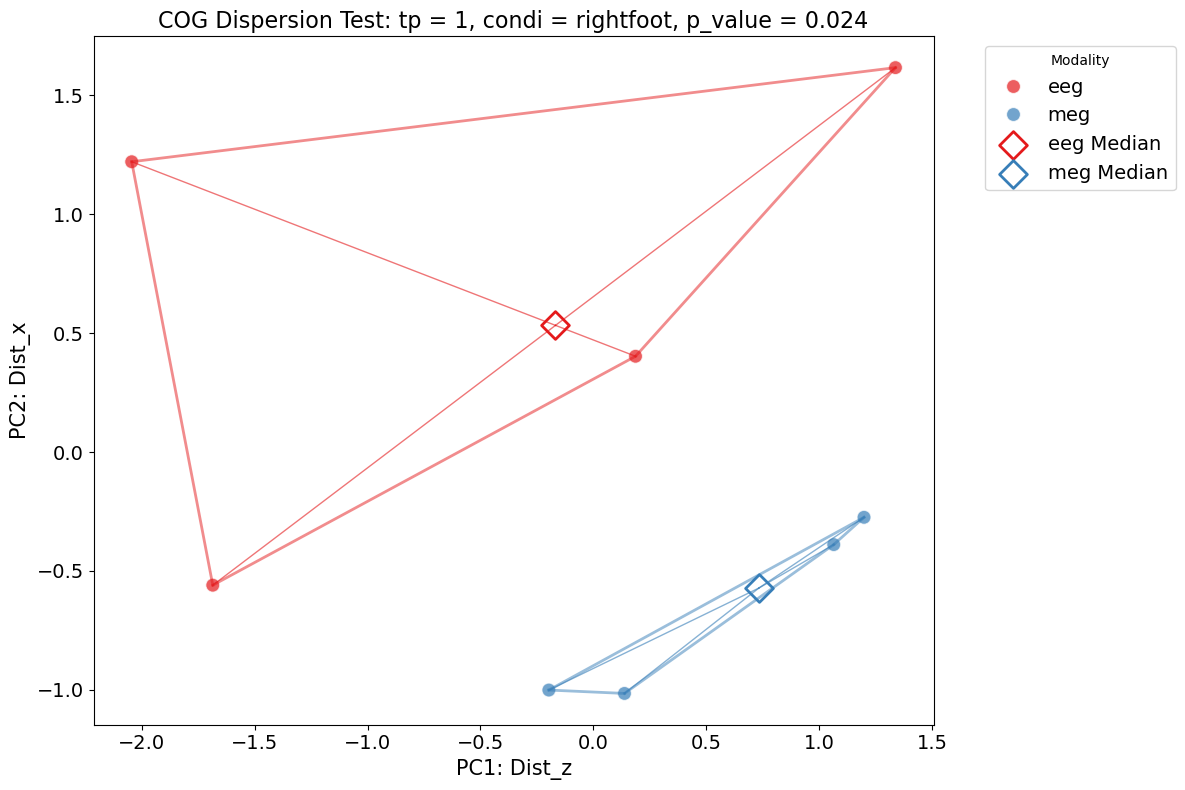

In [34]:
dispertion_study_script = 'Python'
nb_permu = 999
dist_metric = 'euclidean'

if dispertion_study_script not in ['R', 'Python']:
        raise ValueError("Only 'R' or 'Python' scripts are available.")

print(f"Using the {dispertion_study_script} script for dispersion analysis.")

try:
    if dispertion_study_script == 'R':
        for analysis_type in ['POA', 'COG']:
            print(f'Beginning {analysis_type} dispersion analysis using R.')
            path_to_data = path_to_data = f"{LOCAL_DIR}\\derivatives\\results\\{analysis_type}" 
            dispersion_analysis_R(working_directory, path_to_data, rscript_executable, analysis_type=analysis_type, nb_permu=nb_permu, dist_metric=dist_metric)
        
    elif dispertion_study_script == 'Python':
        for analysis_type in ['POA', 'COG']:
            print(f'Beginning {analysis_type} dispersion analysis using Python.')
            path_to_data = path_to_data = f"{LOCAL_DIR}\\derivatives\\results\\{analysis_type}" 
            dispersion_analysis_python(path_to_data, analysis_type=analysis_type, nb_permu=nb_permu, dist_metric=dist_metric)
        

except Exception as e:
    raise ValueError(f"An error occurred during the dispersion analysis using {dispertion_study_script}: {e}")